In [2]:
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import plotly.express as px

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#import os as os; os.remove('paper-Ftable.pkl')
%run utils/Paper_Histogramas_Configuracion.ipynb

[*] => catalogue <= [*]
[*] Se carga el archivo: paper-Ftable.pkl
       Cantidad de datos: 662945 (tablas/photo_fornax_23fields_catalog_v13sep2021_dec_corr.fits)

       Cantidad de datos filtrados: 9115

[*] => Fornax
       Cantidad de datos: 244 (tablas/photo_fornax_literature_catalog_v13sep2021_dec_corr_v2_extinc.fits)
       Cantidad de datos filtrados: 144

[*] => Background (cross-match de 3 arcsec)
       Se encontraron 282 fuentes duplicadas (ID)
       Cantidad de datos: 1353 (tablas/SpecZ_Catalogue_V6_Fornax.fits)

[*] => SPLUS
       Cantidad de datos: 7631


---

In [40]:
# Selecciona filtro G_auto
f = filters[5].replace("_auto","")
#
# Modifico el THETA_IMAGE para que abarque 0 a pi/2 y agrego el label
for tabla, label in zip([ Fornax, Background, Splus ], [ 'Fornax', 'Background', 'Splus' ]):
    tabla['THETA_IMAGE2'] = tabla.apply ( lambda x: 180.0 - np.abs(x['THETA_IMAGE']) if x['THETA_IMAGE'] < 0 else x['THETA_IMAGE'], axis = 1 )
    tabla['label'] = label

    list = []
    for pair in itertools.combinations ( filters, r = 2 ):
        tabla[ pair[0] + '-' + pair[1] ] = tabla [ pair[0] ] - tabla [ pair[1] ]
        list.append(pair[0] + '-' + pair[1])
#
columnas = [ 'R_t_' + f + ' [arcsec]', 'R_e_' + f + ' [arcsec]', '<mu_e_' + f + '>', f + '_auto', 'A_IMAGE', 'B_IMAGE', 'ELONGATION', 'ELLIPTICITY', 'CLASS_STAR_' + f, 
            'THETA_IMAGE2' ]
columnas.extend(['label'])
datos = pd.concat ( [Splus[columnas], Fornax[columnas], Background[columnas]], ignore_index = True )

In [42]:
datos

,R_t_G [arcsec],R_e_G [arcsec],<mu_e_G>,G_auto,A_IMAGE,B_IMAGE,ELONGATION,ELLIPTICITY,CLASS_STAR_G,THETA_IMAGE2,label
0,9.139222,9.139222,25.814055,19.014059,2.769461,1.527993,1.812483,0.448271,0.418564,146.604492,Splus
1,8.979588,6.698437,24.051588,17.926271,4.501188,3.200385,1.406452,0.288991,0.017957,122.616850,Splus
2,10.942846,7.295972,24.612991,18.302126,5.582325,4.188793,1.332681,0.249633,0.020389,35.614014,Splus
3,4.792383,4.337051,25.342777,20.161354,1.452237,1.070294,1.356859,0.263004,0.353215,128.782364,Splus
4,37.048138,14.908084,24.294481,16.431922,12.308985,11.656527,1.055974,0.053007,0.000327,135.952630,Splus
...,...,...,...,...,...,...,...,...,...,...,...
9123,10.453153,7.961767,23.596951,17.096454,5.403997,4.010218,1.347557,0.257916,0.028442,77.775540,Background
9124,13.804540,8.759368,23.542163,16.834349,8.237505,6.067126,1.357728,0.263475,0.020304,52.850803,Background
9125,10.114354,8.208612,23.615761,17.048963,5.278001,5.103095,1.034275,0.033139,0.028657,173.084601,Background
9126,11.511682,8.601647,23.348256,16.679898,8.497507,4.897779,1.734971,0.423622,0.028614,167.431270,Background


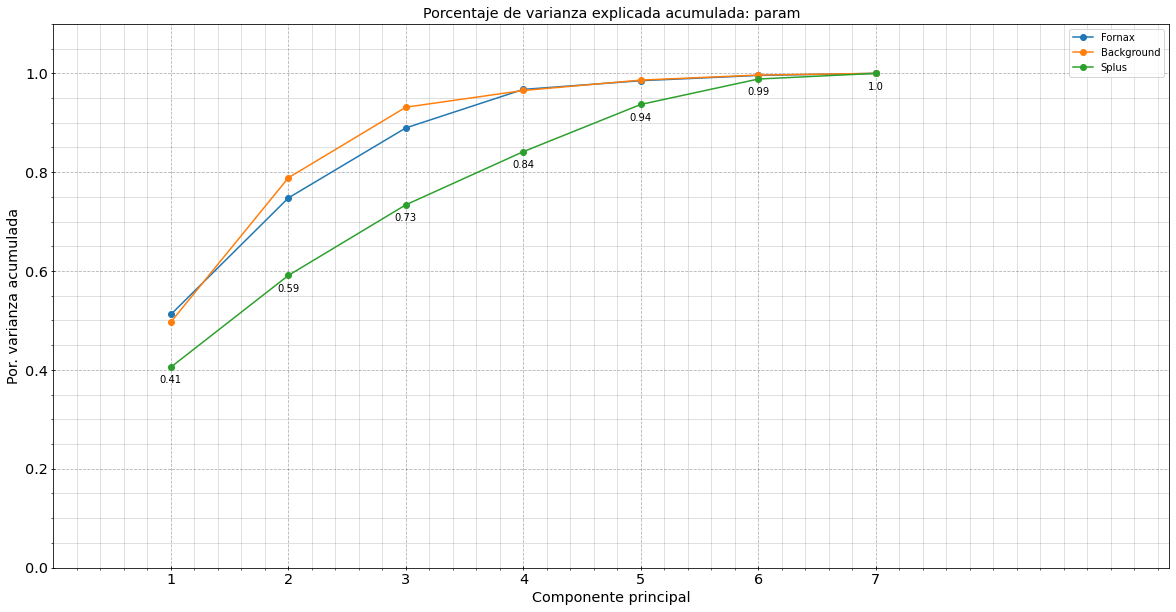

In [120]:
#features = [ x for x in datos if x != 'label' ]
#features = [ 'R_t_' + f + ' [arcsec]', 'R_e_' + f + ' [arcsec]', f + '_auto', 'A_IMAGE', 'B_IMAGE', 'ELONGATION', 'ELLIPTICITY' ] #, 'THETA_IMAGE2' ]
#features = [ 'R_t_' + f + ' [arcsec]', 'R_e_' + f + ' [arcsec]', f + '_auto', 'A_IMAGE', 'ELONGATION', 'ELLIPTICITY' ] #, 'THETA_IMAGE2' ]
features = [ 'A_IMAGE', 'R_t_' + f + ' [arcsec]', 'R_e_' + f + ' [arcsec]', 'B_IMAGE', 'ELONGATION', 'ELLIPTICITY', 'THETA_IMAGE2' ]

prop_varianza_acum = [ ] 
prop_varianza_ratio = [ ] 
prop_components = [ ] 

for l in [ 'Fornax', 'Background', 'Splus' ]:
    data = datos [ datos['label'] == l ][features]
    n_components = len(data.columns)

    # Entrenamiento modelo PCA con escalado de los datos
    # ==============================================================================
    pca_pipe = make_pipeline(StandardScaler(), PCA())
    pca_pipe.fit(data)

    # Se extrae el modelo entrenado del pipeline
    modelo_pca = pca_pipe.named_steps['pca']

    # Porcentaje de varianza explicada acumulada
    # ==============================================================================
    prop_varianza_acum.append ( modelo_pca.explained_variance_ratio_.cumsum() )
    prop_varianza_ratio.append ( modelo_pca.explained_variance_ratio_ )
    prop_components.append ( modelo_pca.components_ )

fig, ax = plt.subplots ( nrows = 1, ncols = 1, figsize = (20, 10) )

for i, l in enumerate([ 'Fornax', 'Background', 'Splus' ]):
    ax.plot(
        np.arange(n_components) + 1,
        prop_varianza_acum[i],
        marker = 'o',
        label = l
    )

for x, y in zip(np.arange(n_components) + 1, prop_varianza_acum[2]):
    labelp = round(y, 2)
    ax.annotate(
        labelp,
        (x,y),
        textcoords = "offset points",
        xytext = (0,-16),
        ha = 'center'
    )

ax.minorticks_on()
ax.grid ( b = True, which = 'major', color = 'black', linestyle = '--', alpha = 0.3, zorder = 0.0 )
ax.grid ( b = True, which = 'minor', color = 'gray', linestyle = '-', alpha = 0.3, zorder = 0.0 )
ax.tick_params ( axis = "y", direction = "inout" )
ax.tick_params ( axis = "x", direction = "inout" )

ax.set_ylim(0, 1.1)
ax.set_xlim(0, 9.5)
#ax.set_xticks(np.arange(9) + 1.0)  
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada: param')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')
ax.legend()
plt.savefig ( "figures/PCA-param-01.jpg", dpi = 250, facecolor = 'w', edgecolor = 'w',
            orientation = 'portrait', format = None, transparent = False, 
            bbox_inches = 'tight', pad_inches = 0.01 )
plt.show()

In [121]:
var_exp = pd.DataFrame()
#
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
for i, l in enumerate([ 'Fornax', 'Background', 'Splus' ]):
    var_exp.loc[:, l] = pd.Series( prop_varianza_ratio[i], name = l, index = [ "PC" + str(j+1) for j in range(len(prop_varianza_ratio[i])) ] )

var_exp

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------


,Fornax,Background,Splus
PC1,0.512243,0.496993,0.405634
PC2,0.235690,0.291751,0.185540
PC3,0.141719,0.142807,0.142885
PC4,0.077937,0.033831,0.107552
PC5,0.017548,0.020987,0.095502
PC6,0.010679,0.010213,0.051433
PC7,0.004185,0.003418,0.011453


In [122]:
comp = pd.DataFrame()

for i, l in enumerate([ 'Fornax', 'Background', 'Splus' ]):
    print (l)
    # Se combierte el array a dataframe para añadir nombres a los ejes.
    display ( pd.DataFrame ( data = prop_components[i], columns = data.columns, index = [ "PC" + str(j+1) for j in range(len(prop_components[i])) ] ) )

Fornax


,A_IMAGE,R_t_G [arcsec],R_e_G [arcsec],B_IMAGE,ELONGATION,ELLIPTICITY,THETA_IMAGE2
PC1,0.484719,0.491230,0.429161,0.270429,0.382333,0.342669,-0.053186
PC2,0.177453,0.148690,0.123690,0.603292,-0.505407,-0.547918,-0.107196
PC3,-0.084495,-0.029089,0.042933,-0.118419,0.055916,-0.014568,-0.986311
PC4,-0.373334,0.264833,0.721350,-0.425585,-0.147915,-0.238274,0.101802
PC5,-0.222944,-0.536958,0.428602,0.376960,-0.247027,0.524377,-0.013417
PC6,-0.115923,0.528519,-0.269577,-0.105615,-0.609343,0.499929,-0.046639
PC7,-0.723808,0.312962,-0.148195,0.463150,0.375578,-0.021836,0.012333


Background


,A_IMAGE,R_t_G [arcsec],R_e_G [arcsec],B_IMAGE,ELONGATION,ELLIPTICITY,THETA_IMAGE2
PC1,0.512846,0.501577,0.481758,0.447928,0.166387,0.157739,-0.010589
PC2,0.096315,-0.083910,-0.143412,-0.334504,0.652118,0.652358,-0.019831
PC3,0.004929,-0.012126,-0.013589,0.009929,-0.012541,-0.018031,-0.999531
PC4,-0.466512,0.242459,0.694917,-0.485504,-0.046109,0.049373,-0.019825
PC5,-0.103634,0.794255,-0.476807,-0.224623,0.142805,-0.245388,-0.003261
PC6,0.142322,-0.225004,0.190973,-0.106568,0.631949,-0.694199,0.004370
PC7,0.692141,-0.031274,0.020813,-0.624374,-0.353583,-0.068247,0.002975


Splus


,A_IMAGE,R_t_G [arcsec],R_e_G [arcsec],B_IMAGE,ELONGATION,ELLIPTICITY,THETA_IMAGE2
PC1,0.503095,0.547636,0.538726,0.318671,0.194940,0.130021,0.017496
PC2,0.086437,-0.105558,-0.105988,-0.414094,0.605619,0.657156,-0.007048
PC3,0.006670,-0.031782,-0.026805,0.022764,0.024602,-0.007924,0.998519
PC4,0.117167,-0.204012,-0.231271,0.339947,0.707039,-0.523320,-0.042808
PC5,-0.049744,-0.232329,-0.252517,0.767079,-0.123071,0.525019,-0.024131
PC6,0.848762,-0.253928,-0.333743,-0.149544,-0.282064,-0.040679,-0.012675
PC7,0.052724,-0.726543,0.684972,0.010886,-0.002727,-0.003849,-0.005301


In [123]:
l_train = 'Fornax'
train = datos [ datos['label'] == l_train ][features]

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit ( train )

# Proyección de las observaciones de entrenamiento
# ==============================================================================
l = 'Splus'
data = datos [ datos['label'] == l ][features]

proyecciones = pca_pipe.transform( X = data )
proyecciones = pd.DataFrame ( proyecciones, columns = [ "PC" + str(j+1) for j in range(len(data.columns)) ] )
proyecciones#.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-1.603617,-1.761178,-0.819572,0.262876,0.326098,0.030733,0.015218
1,-2.049635,-0.922972,-0.431245,0.125377,-0.016132,0.006962,-0.105065
2,-1.908524,-0.479632,1.186932,0.013142,-0.066217,0.058954,-0.126861
3,-2.529208,-1.106452,-0.504812,0.106113,-0.126277,-0.014815,-0.130219
4,-0.902910,0.993032,-0.865665,0.938835,-0.613410,0.043308,0.211936
...,...,...,...,...,...,...,...
7626,-2.417034,-1.495186,-1.121281,0.045511,0.005841,0.014773,-0.072624
7627,-1.381714,-2.158470,1.907797,-0.472423,0.410954,0.122534,0.176102
7628,-2.442715,-1.247709,1.097790,-0.312409,-0.047448,0.143291,-0.093515
7629,-1.365704,-1.032032,1.560803,0.244826,0.223540,0.189696,-0.050670


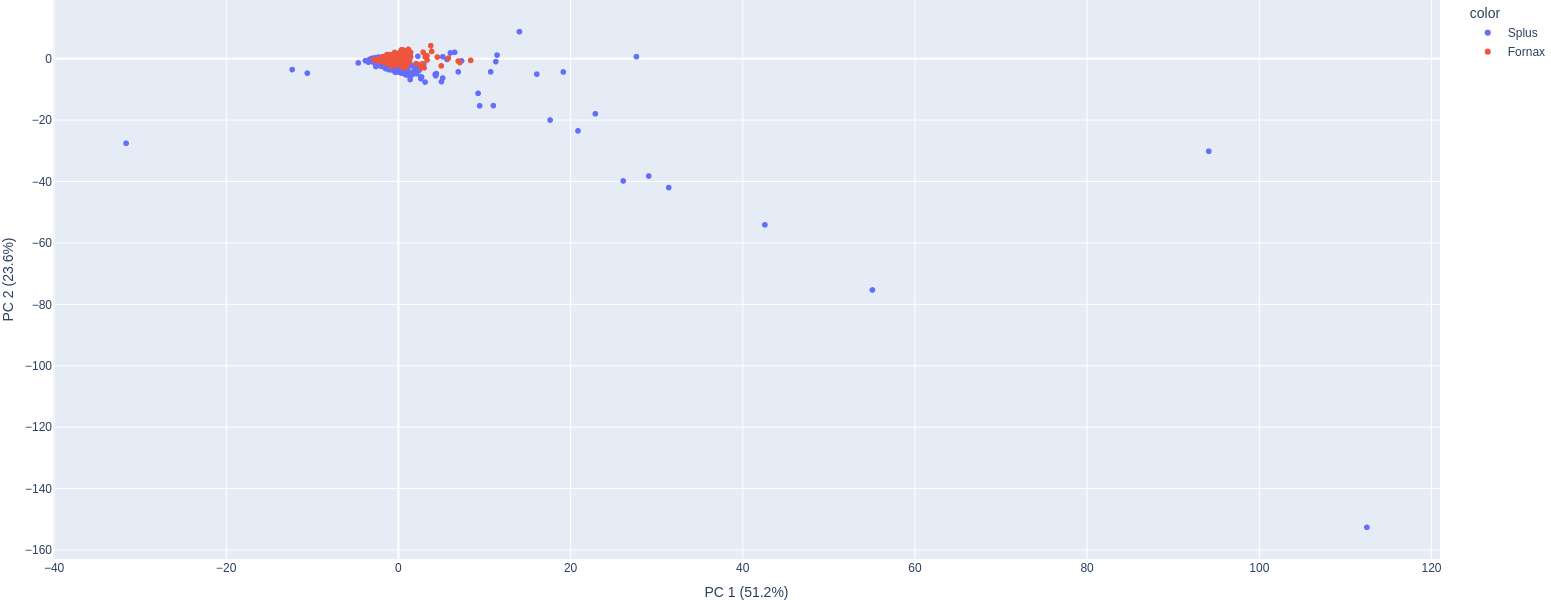

In [124]:
l_train = 'Fornax'
train = datos [ datos['label'] == l_train ][features]

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit ( train )

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
    
d = datos[ (datos['label'] == 'Fornax') | (datos['label'] == 'Splus') ]
d.sort_values ( by = 'label', key = lambda x: x.map({'Background': 0, 'Splus': 1, 'Fornax': 3} ), inplace = True )
#
components = pca_pipe.transform ( d[features] )

labels = [ f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(modelo_pca.explained_variance_ratio_ * 100) ]

fig = px.scatter ( x = components[:,0], y = components[:,1], color = d['label'] )
fig.update_layout ( xaxis_title = labels[0], yaxis_title = labels[1], autosize = False, 
                   width = 600, height = 600, showlegend = True, margin = {"l":0,"r":0,"t":0,"b":0} )

fig.write_html("figures/PCA-param-02-Splus_Fornax.html")
fig.write_image("figures/PCA-param-02-Splus_Fornax.jpeg")
fig.show()

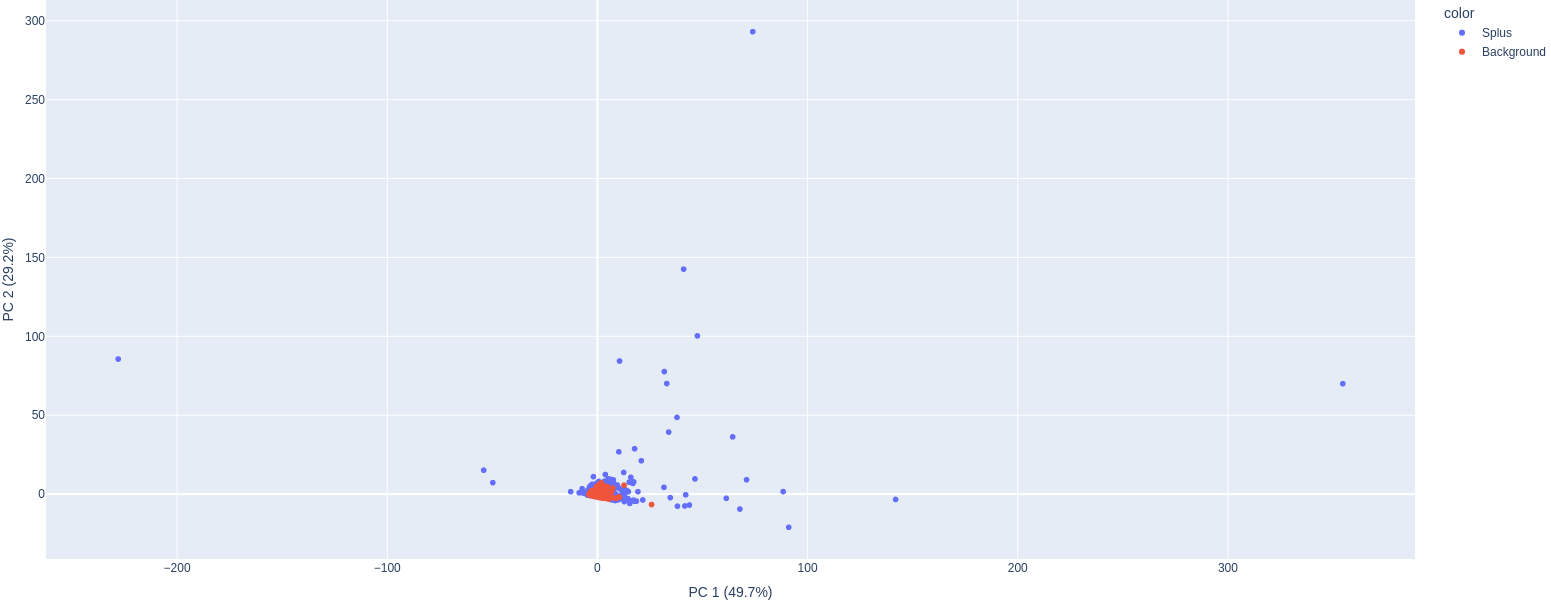

In [125]:
l_train = 'Background'
train = datos [ datos['label'] == l_train ][features]

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit ( train )

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
    
d = datos[ (datos['label'] == 'Background') | (datos['label'] == 'Splus') ]
d.sort_values ( by = 'label', key = lambda x: x.map({'Fornax': 0, 'Splus': 1, 'Background': 3} ), inplace = True )
#
components = pca_pipe.transform ( d[features] )

labels = [ f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(modelo_pca.explained_variance_ratio_ * 100) ]

fig = px.scatter ( x = components[:,0], y = components[:,1], color = d['label'] )
fig.update_layout ( xaxis_title = labels[0], yaxis_title = labels[1], autosize = False, 
                   width = 600, height = 600, showlegend = True, margin = {"l":0,"r":0,"t":0,"b":0} )

fig.write_html("figures/PCA-param-02-Splus_Background.html")
fig.write_image("figures/PCA-param-02-Splus_Background.jpeg")
fig.show()

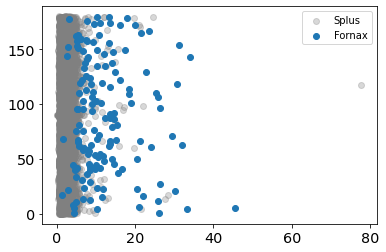

In [110]:
plt.scatter (Splus['B_IMAGE'], Splus['THETA_IMAGE2'], color="gray", alpha=0.3, label = "Splus")
#plt.scatter (Background['B_IMAGE'], Background['THETA_IMAGE2'], alpha = 0.1, label="BACK")
plt.scatter (Fornax['B_IMAGE'], Fornax['THETA_IMAGE2'], label = "Fornax")
plt.legend()

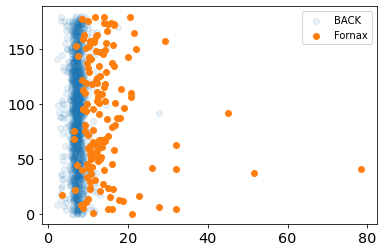

In [115]:
#plt.scatter (Splus['R_t_G [arcsec]'], Splus['THETA_IMAGE2'], color="gray", alpha=0.3, label = "Splus")
plt.scatter (Background['R_e_G [arcsec]'], Background['THETA_IMAGE2'], alpha = 0.1, label="BACK")
plt.scatter (Fornax['R_e_G [arcsec]'], Fornax['THETA_IMAGE2'], label = "Fornax")
plt.legend()

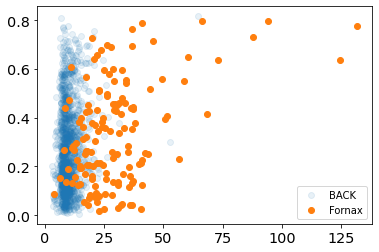

In [118]:
#plt.scatter (Splus['R_t_G [arcsec]'], Splus['THETA_IMAGE2'], color="gray", alpha=0.3, label = "Splus")
plt.scatter (Background['R_t_G [arcsec]'], Background['ELLIPTICITY'], alpha = 0.1, label="BACK")
plt.scatter (Fornax['R_t_G [arcsec]'], Fornax['ELLIPTICITY'], label = "Fornax")
plt.legend()

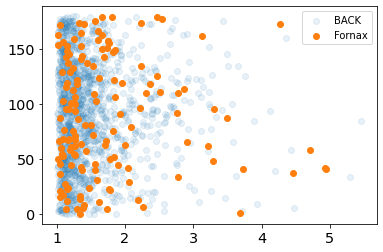

In [116]:
#plt.scatter (Splus['ELONGATION'], Splus['THETA_IMAGE2'], color="gray", alpha=0.3, label = "Splus")
plt.scatter (Background['ELONGATION'], Background['THETA_IMAGE2'], alpha = 0.1, label="BACK")
plt.scatter (Fornax['ELONGATION'], Fornax['THETA_IMAGE2'], label = "Fornax")
plt.legend()

In [112]:
R_t_G [arcsec]

1353